Adaptive Distances
==================

In this example, we show how and when to use the adaptive distances feature of pyabc. "Adaptive distances" means that the distance function is not pre-defined (e.g. after pre-processing), but evolves over time during the ABC run, depending on the observed summary statistics. This can be useful if different summary statistics vary on different scales, but it is not immediately clear how to weight them. For this case, in adaptive distances weights are adjusted in each iteration so as to balance the impact of all summary statistics on the computed distance. 

Currently, adaptively weighted p-norm distances (e.g. Euclidean) are implemented in pyABC, but it is easily possible to define arbitrary adaptive distances.

For illustration, we consider a simple Gaussian model:

In [1]:
import scipy
import tempfile
import os
import matplotlib.pyplot as pyplot
import pyabc.visualization
import logging


# for debugging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)

# model definition
def model(p):
    return {'ss1': p['theta'] + 1 + 0.1*scipy.randn(),
            'ss2': 2 + 10*scipy.randn()}

# true model parameter
theta_true = 3

# observed summary statistics
observation = {'ss1': theta_true + 1, 'ss2': 2}

# prior distribution
prior = pyabc.Distribution(theta=pyabc.RV('uniform', 0, 10))

# database
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")

Summary statistic ss2 has a high variance compared to summary statistic ss1. In addition, ss1 is informative about the model parameters $\theta$, ss2 not. We expect that the proposal distribution for $\theta$ iteratively centers around the true value $\theta=3$. Thus, the variability for the sampled ss1 decreases iteratively, while the variability of the sampled ss2 stays approximately constant. If both summary statistics are weighted similarly in the calculation of the distance between sample and observation, there is hence an undesirable high impact of ss2, so that convergence can be slowed down. In contrast, if we weight ss1 higher, we may hope that our estimation of $\theta$ is improved.

These informal expectations being stated, let us continue with the implementation. First, we consider a non-adaptive Euclidean distance:

In [2]:
distance = pyabc.PNormDistance(p=2)

abc = pyabc.ABCSMC(model, prior, distance)

abc.new(db_path, observation)

history0 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

INFO:History:Start <ABCSMC(id=3, start_time=2019-10-01 10:06:02.440587, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 7.844284805786739
INFO:ABC:t:0 eps:7.844284805786739
INFO:ABC:Acceptance rate: 0.47393364928909953.
INFO:ABC:t:1 eps:4.247438890068936
INFO:ABC:Acceptance rate: 0.2028397565922921.
INFO:ABC:t:2 eps:2.829658727430194
INFO:ABC:Acceptance rate: 0.176056338028169.
INFO:ABC:t:3 eps:1.854052936492626
INFO:ABC:Acceptance rate: 0.10030090270812438.
INFO:ABC:t:4 eps:1.393397572166047
INFO:ABC:Acceptance rate: 0.06958942240779402.
INFO:ABC:t:5 eps:1.000126647287466
INFO:ABC:Acceptance rate: 0.04363001745200698.
INFO:ABC:t:6 eps:0.7087765289527894
INFO:ABC:Acceptance rate: 0.037821482602118005.
INFO:ABC:t:7 eps:0.5352066628375928
INFO:ABC:Acceptance rate: 0.024044241404183698.
INFO:History:Done <ABCSMC(id=3, start_time=2019-10-01 10:06:02.440587, end_time=2019-10-01 10:06:19.568832)>


Let us visualize the results for the non-adaptive distance:

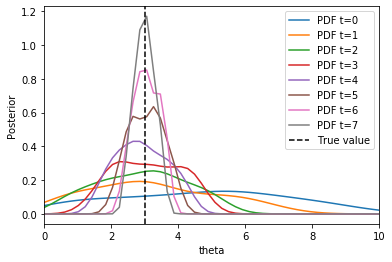

In [3]:
# plotting

fig, ax = pyplot.subplots()
for t in range(history0.max_t + 1):
    df, w = history0.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                   x='theta', ax=ax,
                                   label="PDF t={}".format(t))
ax.axvline(theta_true, color='k', linestyle='dashed', label="True value")
ax.legend()

Second, we consider an adaptive Euclidean distance:

In [4]:
distance_adaptive = pyabc.AdaptivePNormDistance(p=2)

abc = pyabc.ABCSMC(
    model, prior, distance_adaptive,
    acceptor = pyabc.UniformAcceptor(use_complete_history=True))

abc.new(db_path, observation)

history1 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

INFO:History:Start <ABCSMC(id=4, start_time=2019-10-01 10:06:20.001748, end_time=None)>
INFO:ABC:Calibration sample before t=0.
DEBUG:Distance:update distance weights = {'ss1': 1.5760843034014955, 'ss2': 0.4239156965985044}
INFO:Epsilon:initial epsilon is 5.896587453450326
INFO:ABC:t:0 eps:5.896587453450326
INFO:ABC:Acceptance rate: 0.5025125628140703.
DEBUG:Distance:update distance weights = {'ss1': 1.551496515636773, 'ss2': 0.44850348436322707}
INFO:ABC:t:1 eps:3.8851454102748173
INFO:ABC:Acceptance rate: 0.36363636363636365.
DEBUG:Distance:update distance weights = {'ss1': 1.6770910504106342, 'ss2': 0.32290894958936606}
INFO:ABC:t:2 eps:2.3377235551189965
INFO:ABC:Acceptance rate: 0.3021148036253776.
DEBUG:Distance:update distance weights = {'ss1': 1.7757428290637427, 'ss2': 0.22425717093625736}
INFO:ABC:t:3 eps:1.3315440683198272
INFO:ABC:Acceptance rate: 0.22172949002217296.
DEBUG:Distance:update distance weights = {'ss1': 1.8697380120089009, 'ss2': 0.13026198799109923}
INFO:ABC:t

In the debug output of abc.run above, it can be seen how the weights evolve over time. Note that we set the acceptor to use the full history of previous acceptance criteria in order to get nested acceptance regions. This is optional here but may be beneficial sometimes. Let us visualize the results for the adaptive distance:

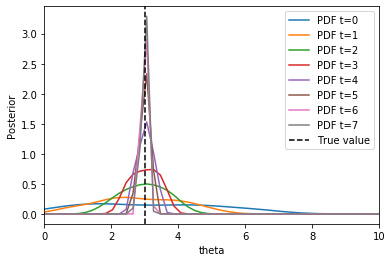

In [5]:
# plotting

fig, ax = pyplot.subplots()
for t in range(history1.max_t + 1):
    df, w = history1.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                   x='theta', ax=ax,
                                   label="PDF t={}".format(t))
ax.axvline(theta_true, color='k', linestyle='dashed', label="True value")
ax.legend()

We observe differences compared to the non-adaptive setting. In particular, the densitities tend to be narrower around the true parameter $\theta=3$. In addition, despite, the better convergence, the required number of samples in total is lower, as not so much time was wasted trying to match an uninformative summary statistic:

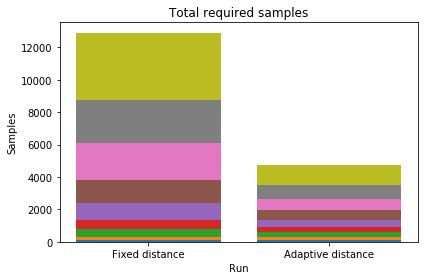

In [6]:
pyabc.visualization.plot_sample_numbers([history0, history1], ["Fixed distance", "Adaptive distance"])

In detail, the adaptive distance feature works as follows: In each iteration of the ABCSMC run, after having obtained the desired number of accepted particles (and once at the beginning using a sample from the prior), the method ``DistanceFunction.update()`` is called. It is given a set of summary statistics which can be used to e.g. compute weights for the distance measure in the next iteration. In order to avoid bias, via ``DistanceFunction.configure_sampler()``, the distance function can tell the sampler to not only record accepted particles, but all that were generated during the sampling process.
So, when you want to define your own adaptive distance function, you will typically only need to overwrite these two methods. For implementation details and an example of how this can look in practice, please inspect the code of ``AdaptivePNormDistance``.